In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath(".."))

from eda.models import Generation, Participant
from eda.parsing import Conversations, Participants
from eda.utils import round_precise

participants = Participants()
conversations = Conversations(participants)

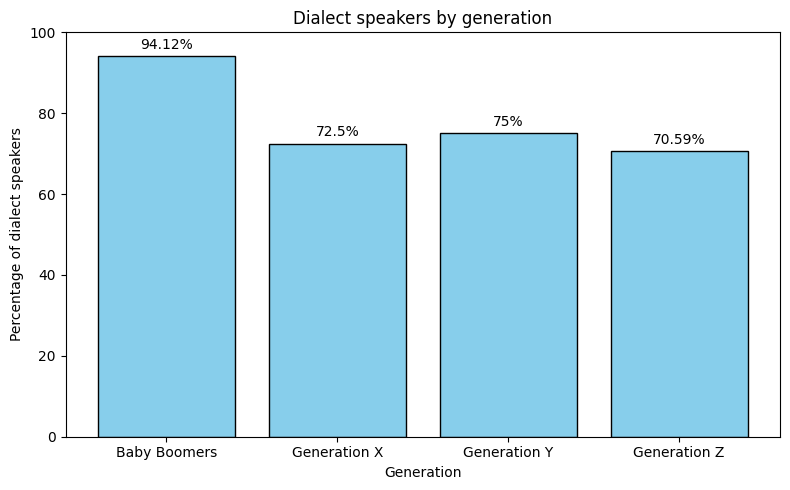

In [2]:
def participant_speaks_dialect(participant: Participant) -> bool:
    return bool(conversations.participant_dialect_words(participant))


dialect_counts: dict[Generation, list[int]] = Generation.create_mapping()
for generation in dialect_counts:
    dialect_counts[generation].extend((0, 0))

for participant in participants:
    percentages = dialect_counts[participant.generation]
    percentages[0] += participant_speaks_dialect(participant)
    percentages[1] += 1

generation_names = []
percentages = []
for generation, (speaker_count, participant_count) in dialect_counts.items():
    percentage = round_precise(speaker_count / participant_count * 100, 2)
    generation_names.append(generation.name)
    percentages.append(percentage)

plt.figure(figsize=(8, 5))
plt.bar(generation_names, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Generation")
plt.ylabel("Percentage of dialect speakers")
plt.title("Dialect speakers by generation")
plt.ylim(0, 100)

for i, value in enumerate(percentages):
    plt.text(i, value + 1, f"{value}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [3]:
conversations.read_all()

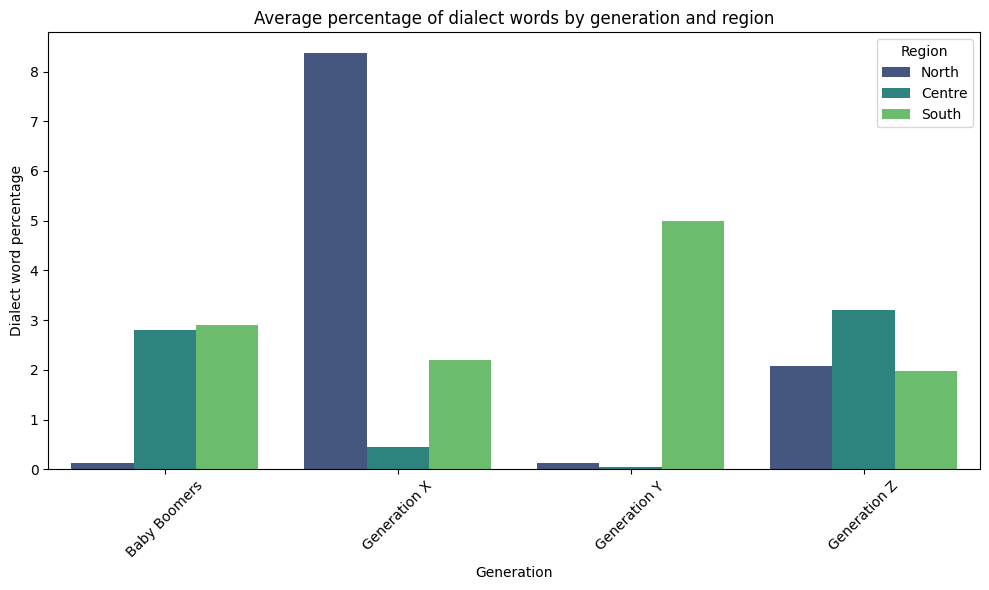

In [4]:
from collections.abc import Generator
from functools import cache

from eda.language import AttributedWord
from eda.models import MacroRegion, ParticipantLines
from eda.utils import round_precise


def participant_macro_region(participant: Participant) -> MacroRegion:
    conversation = conversations.conversation(participant.conversation_code)
    return conversation.macro_region


def generate_participant_words(lines: ParticipantLines) -> Generator[AttributedWord]:
    for line in lines:
        yield from filter(lambda word: word.is_linguistic, line.normalised_words)

def participant_dialect_percentage(participant: Participant) -> int | float:
    participant_lines = conversations.participant_lines(participant)
    dialect_words = total_words = 0
    for word in generate_participant_words(participant_lines):
        dialect_words += word.is_dialect(strict=False)
        total_words += 1

    return round_precise(dialect_words / total_words * 100, 2)

@cache
def participants_dialect_percentages() -> list[int | float]:
    percentages = []
    for participant in participants:
        percentages.append(participant_dialect_percentage(participant))
    return percentages


percentages = participants_dialect_percentages()
generations = [participant.generation.name for participant in participants]
macro_regions = [
    participant_macro_region(participant).name.capitalize()
    for participant in participants
]

df = pd.DataFrame({
    "dialect_percentage": percentages,
    "generation": generations,
    "region": macro_regions,
})

grouped = (
    df.groupby(["generation", "region"], observed=True)
    .agg(
        dialect_percentage=("dialect_percentage", "mean"),
        n_speakers=("dialect_percentage", "count"),
    )
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=grouped,
    x="generation",
    y="dialect_percentage",
    hue="region",
    hue_order=["North", "Centre", "South"],
    palette="viridis",
)

plt.title("Average percentage of dialect words by generation and region")
plt.ylabel("Dialect word percentage")
plt.xlabel("Generation")
plt.legend(title="Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

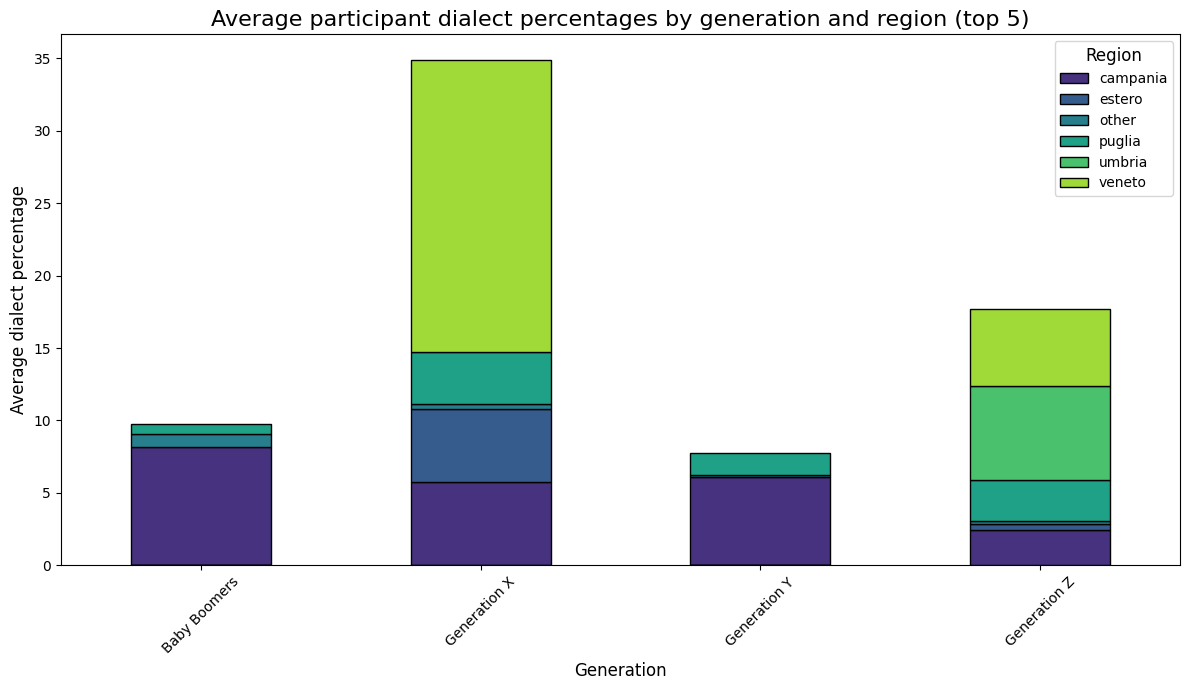

In [5]:
from collections import defaultdict
from functools import cache
from typing import Optional


@cache
def generational_dialect_percentages(top_n: Optional[int] = None) -> pd.DataFrame:
    data = []
    region_percentages = defaultdict(float)

    dialect_percentages = iter(participants_dialect_percentages())
    for participant in participants:
        region = participant.geographic_origin
        percentage = next(dialect_percentages)
        participant_data = {
            "generation": participant.generation.name,
            "dialect_percentage": percentage,
            "region": region
        }
        region_percentages[region] += percentage
        data.append(participant_data)

    top_regions = frozenset(
        region for region, _ in sorted(
            region_percentages.items(), key=lambda pair: pair[1], reverse=True
        )[:top_n]
    )

    for participant_data in data:
        region = participant_data["region"]
        if region not in top_regions:
            participant_data["region"] = "other"

    df = pd.DataFrame(data)
    df = df.groupby(["generation", "region"])["dialect_percentage"].mean().unstack()
    df = df.sort_values(by="generation")
    df = df.replace(np.nan, 0.0)
    return df


top_n = 5
region_dialects_df = generational_dialect_percentages(top_n=top_n)
plt.figure(figsize=(12, 7))

colors = sns.color_palette("viridis", n_colors=len(region_dialects_df.columns))

region_dialects_df.plot(
    kind="bar",
    stacked=True,
    color=colors,
    ax=plt.gca(),
    edgecolor="black"
)

plt.title(f"Average participant dialect percentages by generation and region (top {top_n})", fontsize=16)
plt.ylabel("Average dialect percentage", fontsize=12)
plt.xlabel("Generation", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Region", fontsize=10, title_fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()


In [6]:
from functools import cache, partial
from typing import Any, cast


@cache
def get_region_dialects_df() -> pd.DataFrame:
    region_dialects_df = generational_dialect_percentages()
    region_dialects_df = region_dialects_df[region_dialects_df.columns]
    region_dialects_df = pd.DataFrame(region_dialects_df.apply(partial(round, ndigits=2), axis=1))
    region_dialects_df = region_dialects_df.loc[:, (region_dialects_df != 0).sum() >= 2]
    return region_dialects_df

def generation_grouped_percentages(region_dialects_df: pd.DataFrame) -> dict[str, Any]:
    percentages = {
        generation.name: {}
        for generation in Generation.create_mapping()
    }

    for i, row in region_dialects_df.iterrows():
        values = {
            key: float(cast(np.float64, value)) 
            for key, value in dict(row).items()
        }
        percentages[cast(str, i)] = values

    return percentages

def calculate_regional_deltas(region_dialects_df: pd.DataFrame) -> dict[str, float]:
    def percentage_delta(percentages: list[float]) -> float:
        delta = 0
        prev = percentages[0]
        for percentage in percentages[1:]:
            delta += percentage - prev
            prev = percentage
        return delta
    
    percentages_per_region = defaultdict(list)
    for _, row in region_dialects_df.iterrows():
        for region, percentage in dict(row).items():
            percentages_per_region[region].append(float(percentage))  # type: ignore

    result = {}
    for region, values in percentages_per_region.items():
        values = list(filter(None, values))
        result[region] = round_precise(percentage_delta(values), 2)

    return result


calculate_regional_deltas(get_region_dialects_df())


{'basilicata': 0.41,
 'campania': -5.7,
 'emilia-romagna': -0.26,
 'estero': -4.66,
 'lazio': -0.61,
 'marche': -0.36,
 'puglia': 2.16,
 'sardegna': 0.06,
 'toscana': -3.09,
 'veneto': -14.9}

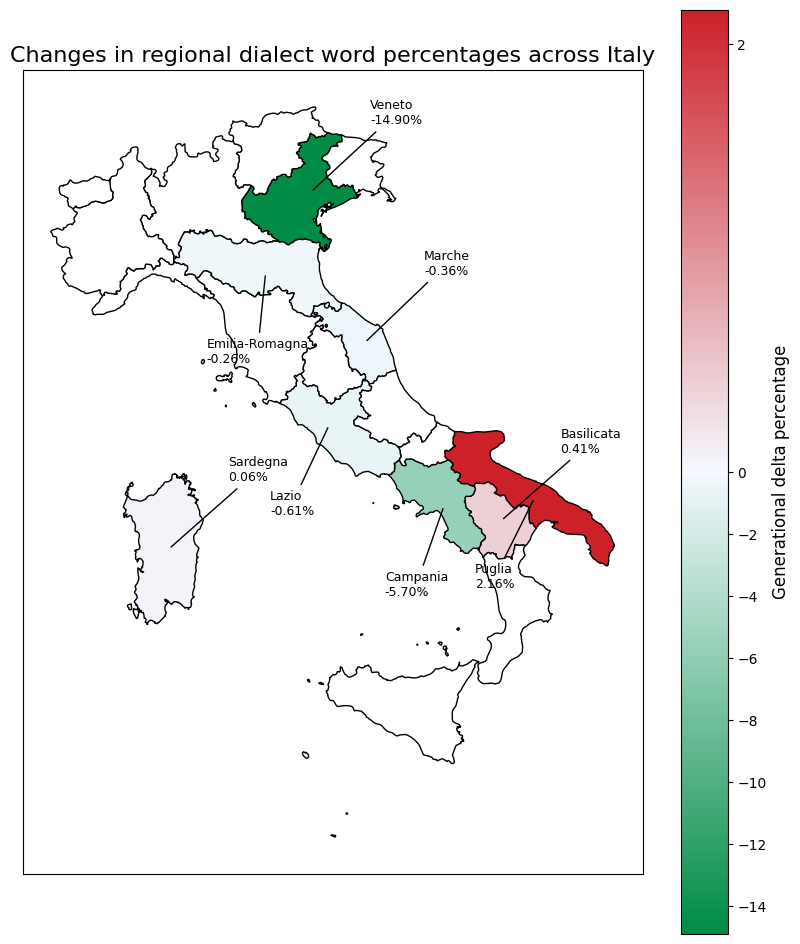

In [7]:
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from eda.utils import FOLDER_DIR

italy_flag = mcolors.LinearSegmentedColormap.from_list(
    "italy_flag", ["#008C45", "#F4F9FF", "#CD212A"]
)

region_dialects_df = get_region_dialects_df()
region_deltas = calculate_regional_deltas(region_dialects_df)

gdf = gpd.read_file(FOLDER_DIR / "data" / "italy_regions.json")
gdf["name"] = gdf["name"].str.lower()
gdf["delta"] = gdf["name"].map(lambda value: region_deltas.get(value, np.nan))

gdf["longtitude"] = gdf.geometry.representative_point().x
gdf = gdf.sort_values("longtitude", ascending=False)

vmin = gdf["delta"].min()
vmax = gdf["delta"].max()

norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize=(10, 12))
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

gdf.plot(
    ax=ax, 
    column="delta",
    edgecolor="black", 
    cmap=italy_flag,
    norm=norm,
    missing_kwds=dict(color="white"),
    legend=True
)

fig.axes[-1].set_ylabel("Generational delta percentage", fontsize=12)

for i, (_, row) in enumerate(gdf.dropna(subset=["delta"]).iterrows()):
    direction = -1 if i % 2 == 0 else 1
    point = row.geometry.representative_point()
    xy = x, y = point.x, point.y

    offset_x = x + 1.25 * direction
    offset_y = y + 1.25 * direction

    ax.annotate(
        f"{row["name"].title()}\n{row["delta"]:.2f}%",
        xy=xy,
        xytext=(offset_x, offset_y),
        ha="left",
        va="center",
        fontsize=9,
        color="black",
        arrowprops=dict(
            arrowstyle='-',
            color="black",
            lw=1
        )
    )

plt.title("Changes in regional dialect word percentages across Italy", fontsize=16)
plt.show()

In [ ]:
from collections import Counter

from eda.models import Conversation

UNKNOWN_EDUCATION = "N/A"
EDUCATION_RANKINGS = [
    "elem", "dip_tec_prof", "dip_lic", "laurea in corso", "laurea", "med", "phd"
]
GENERATION_ORDER = [
    Generation.BOOMERS, Generation.X, Generation.Y, Generation.Z
]

def approximate_participant_age(participant: Participant) -> int | float:
    if participant.age_range.is_oldest():
        return participant.age_range.oldest_age
    else:
        return (participant.age_range.youngest_age + participant.age_range.oldest_age) / 2

def conversation_generation(conversation: Conversation) -> Generation:
    # Lower median
    generations = [participant.generation for participant in conversation.participants]
    counts = Counter(generations)
    most_common, count = counts.most_common(1)[0]
    if count > len(generations) / 2:
        return most_common

    generations.sort(key=GENERATION_ORDER.index)
    median_index = (len(generations) - 1) // 2
    return generations[median_index]

def conversation_average_age(conversation: Conversation) -> float:
    age_ranges = list(map(approximate_participant_age, conversation.participants))
    return round_precise(sum(age_ranges) / len(age_ranges))
    
def conversation_educational_background(conversation: Conversation) -> str:
    # Lowest background
    backgrounds = [participant.degree for participant in conversation.participants]
    counts = Counter(backgrounds)
    most_common, count = counts.most_common(1)[0]
    if count > len(backgrounds) / 2:
        return most_common
    
    return min(backgrounds, key=EDUCATION_RANKINGS.index)
    
def conversation_participant_data(conversation: Conversation) -> dict[str, Any]:
    n_participants = len(conversation.participants)
    dialect_percentages = list(map(participant_dialect_percentage, conversation.participants))

    result = {}
    result["n_participants"] = n_participants
    result["dialect_percentage"] = round_precise(sum(dialect_percentages) / n_participants)

    sort = {}
    sort["average_approximate_age"] = conversation_average_age(conversation)
    sort["generation"] = conversation_generation(conversation)
    sort["region"] = conversation.macro_region.name.lower()
    sort["educational_background"] = conversation_educational_background(conversation)
    result["sort"] = sort
    return result

{'n_participants': 2,
 'dialect_percentage': 1.56,
 'sort': {'average_approximate_age': 38,
  'generation': Generation('Generation X', 51—65),
  'region': 'centre',
  'educational_background': 'dip_tec_prof'}}